In [1]:
import geopandas as gpd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
plt.style.use('Solarize_Light2')

In [2]:
df= gpd.read_file(r'data/OSM/gis_osm_landuse_a_free_1.shp')
feat_to_predict = 'fclass'

In [3]:
def remove_municipality(city_name, building_df, muni_df):
    '''
    removes specific named muni from the dataset
    '''
    muni_df.to_crs(epsg=26954, inplace=True)
    building_df.to_crs(epsg=26954, inplace=True)
    town = muni_df[muni_df.first_city==city_name]
    town_buildings = gpd.clip(building_df, town)
    return building_df.drop(town_buildings.index, axis=0), town_buildings

df.to_crs(epsg=26954, inplace=True)
df.dropna(subset=[feat_to_predict], inplace=True)

muni = gpd.read_file(r'data/MunicipalBoundariesinColorado.geojson')
muni.to_crs(epsg=26954, inplace=True)

In [4]:
df['areas'] = df.area
df['length'] = df.length
df['X'] = df.centroid.x
df['Y'] = df.centroid.y
le = LabelEncoder()
df['y_le'] = le.fit_transform(df[feat_to_predict])

In [5]:
df_dropped, df_validate = remove_municipality('Boulder', df, muni)

In [6]:
df_clean = df_dropped.drop(['name', 'geometry','osm_id','code', 'fclass'],axis=1)

In [7]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

In [8]:
X = df_clean.drop('y_le', axis=1)
y = df_clean['y_le'] #need to LE earlier on with all the data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=86)

In [9]:
pipe = Pipeline([('scaler', MinMaxScaler()), ('classifier', RandomForestClassifier(n_jobs=4, max_depth=30, n_estimators=100))])
pipe.fit(X_train, y_train)
pipe.score(X_train, y_train)

0.9970088343728987

In [10]:
pipe.score(X_test,y_test)

0.864325393089163

In [11]:
df_val_clean = df_validate.drop([feat_to_predict,'y_le', 'name', 'geometry','osm_id','code'],axis=1)
y_hat = le.inverse_transform(pipe.predict(df_val_clean))
acc = pipe.score(df_val_clean, df_validate.y_le)
labels = set(le.inverse_transform(df_validate.y_le))
labels.add('quarry')
labels.add('scrub')

In [12]:
pipe.score(df_val_clean, df_validate.y_le)

0.4155844155844156

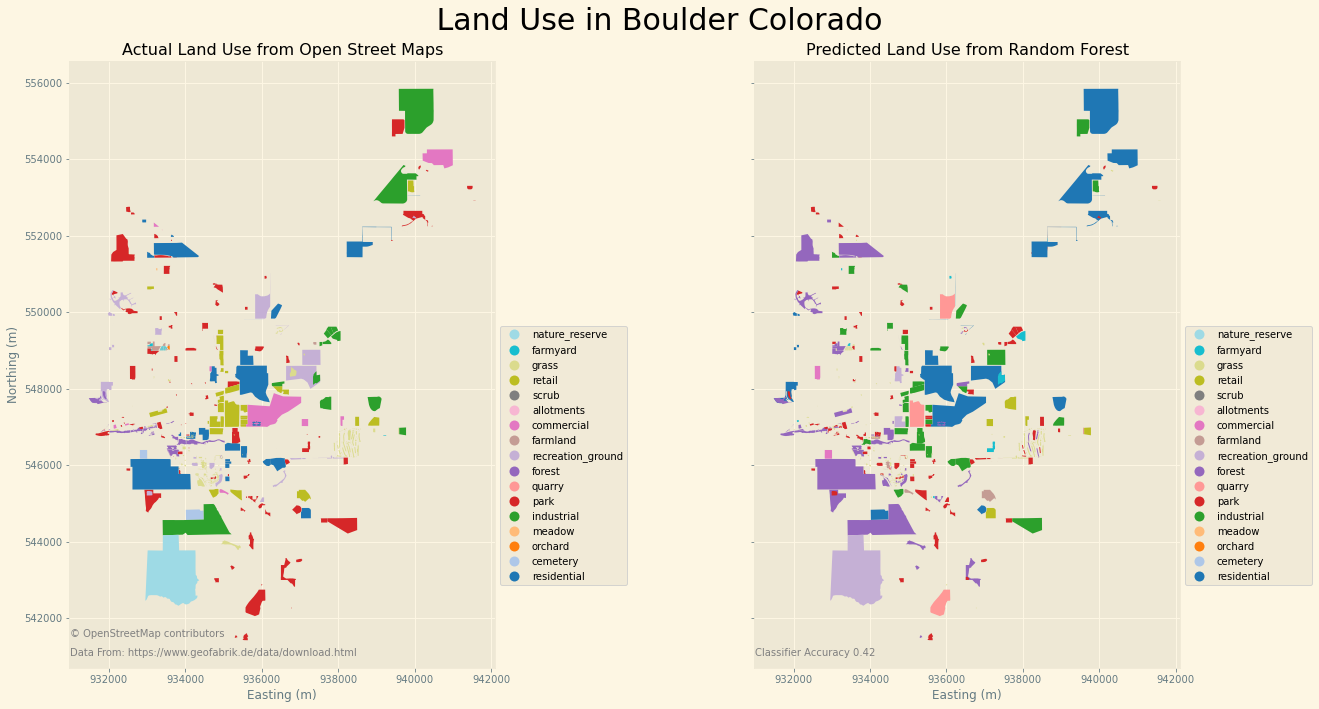

In [20]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(20,10))
fig.suptitle(' Land Use in Boulder Colorado ', fontsize=30)
df_validate.plot(column=feat_to_predict, ax=ax1, categorical=True, legend=True,categories=labels, legend_kwds={'loc': 'center left', 'bbox_to_anchor':(1,0.35)}, cmap='tab20_r')
ax1.set_xlabel('Easting (m)')
ax1.set_ylabel('Northing (m)')
ax1.set_title('Actual Land Use from Open Street Maps')

df_validate.plot(column=y_hat, ax=ax2, categorical=True, legend=True,categories=labels, legend_kwds={'loc': 'center left', 'bbox_to_anchor':(1,0.35)}, cmap='tab20_r')
ax2.set_title('Predicted Land Use from Random Forest')
ax2.set_xlabel('Easting (m)')
ax2.text(931_000, 541_000,f'Classifier Accuracy {acc:.2f}', {'color':'gray'})

ax1.text(931_000, 541_500, r'© OpenStreetMap contributors', {'color': 'gray', 'fontsize': 10})
ax1.text(931_000, 541_000, r'Data From: https://www.geofabrik.de/data/download.html', {'color': 'gray', 'fontsize': 10})
plt.tight_layout()
plt.savefig('Day_5.png')

In [14]:
df_validate['yhat'] = y_hat

Text(0.5, 15.0, 'Predicted Label')

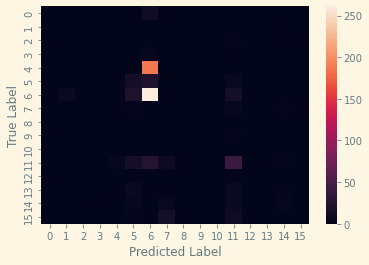

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.heatmap(confusion_matrix(df_validate['fclass'], df_validate.yhat))
plt.ylabel('True Label')
plt.xlabel('Predicted Label')